In [1]:
import django_initializer
from telemetry.models import FastLap, Lap
from telemetry.analyzer import Analyzer
from telemetry.influx import Influx

import plotly.express as px
import plotly.io as pio
import scipy

pio.renderers.default = "svg"  # comment this line to use interactive plots
import plotly.graph_objects as go

import pandas as pd

%load_ext autoreload
%autoreload 2

analyzer = Analyzer()
influx = Influx()

2023-05-25 17:27:15,845 DEBUG Influx: Connected to https://telemetry.b4mad.racing/


In [2]:
def lap_fig(df, mode=None, columns=["Throttle", "Brake"]):
    fig = go.Figure()

    for column in columns:
        color = "red"
        if column == "Throttle":
            color = "green"
        fig.add_scatter(
            x=df["DistanceRoundTrack"],
            y=df[column],
            marker=dict(size=1),
            mode=mode,
            name=column,
            line=dict(color=color),
            showlegend=True,
        )
    return fig


def fig_add_shape(fig, color="black", **kwargs):
    default = dict(
        type="rect",
        xref="x",
        yref="y",
        x0=0,
        y0=0,
        x1=0,
        y1=1,
        line=dict(color=color, width=2, dash="dot"),
    )
    args = {**default, **kwargs}
    fig.add_shape(**args)

In [3]:
# Automobilista 2 - SpaFrancorchamps:Spa_Francorchamps_2022 - Mercedes-Benz CLK LM
# iRacing / richmond / Gen 4 Chevrolet Impala
kwargs = {
    "game__name": "iRacing",
    # "track__name": "fuji nochicane",
    "track__name": "longbeach",
    # "track__name": "nurburgring combined",
    # "track__name": "richmond",
    "car__name": "Ferrari 488 GT3 Evo 2020",
    # "car__name": "Gen 4 Chevrolet Impala",
    # "game__name": "Automobilista 2",
    # "track__name": "SpaFrancorchamps:Spa_Francorchamps_2022",
    # "car__name": "Mercedes-Benz CLK LM",
}
lap_id = 0
# lap_id = 43525

laps = []
if lap_id:
    lap = Lap.objects.get(pk=lap_id)
    laps.append(lap)
else:
    fast_laps = FastLap.objects.filter(**kwargs)
    laps.append(fast_laps.first().laps.first())

data_frames = []
for lap in laps:
    print(lap)
    lap_df = influx.telemetry_for_laps([lap], measurement="fast_laps", bucket="fast_laps")[0]
    data_frames.append(
        {
            "lap": lap,
            "df": lap_df,
        }
    )

2023-05-25 17:27:16,004 INFO Processing iRacing - longbeach - Ferrari 488 GT3 Evo 2020
2023-05-25 17:27:16,004 INFO   track.id 53 car.id 9
2023-05-25 17:27:16,004 INFO   session 1684946930 lap.id 86971 number 1
2023-05-25 17:27:16,004 INFO   length 3138 time 81.4088 valid True
2023-05-25 17:27:16,004 INFO   start 2023-05-24 18:50:42.382732+00:00 end 2023-05-24 18:52:03.784981+00:00


1: 18:50:42 - 18:52:03 81.4088s 3138m valid: True


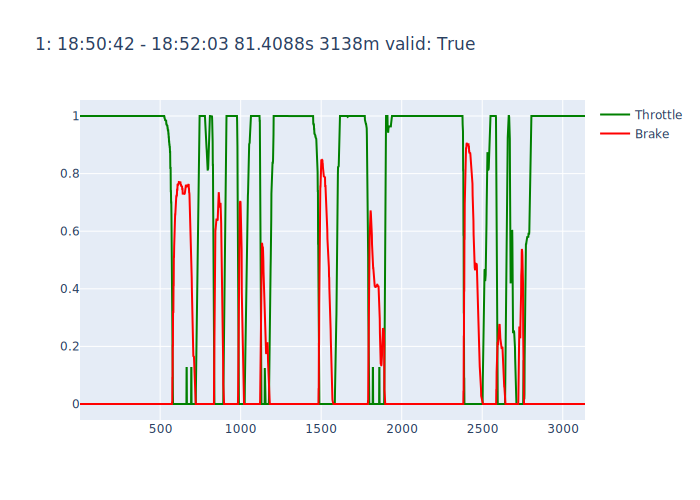

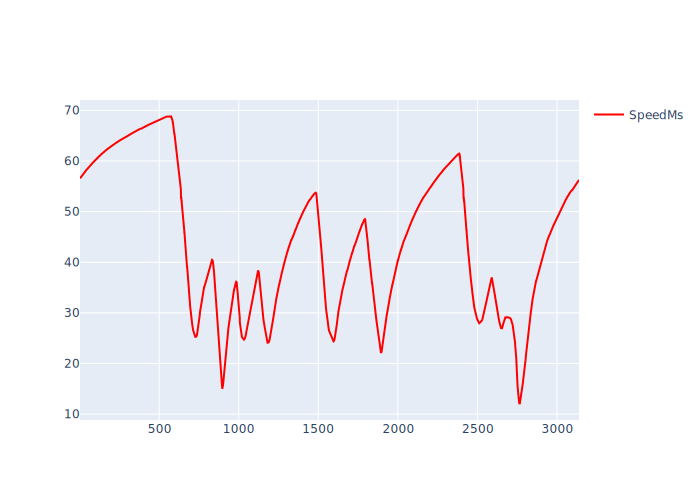

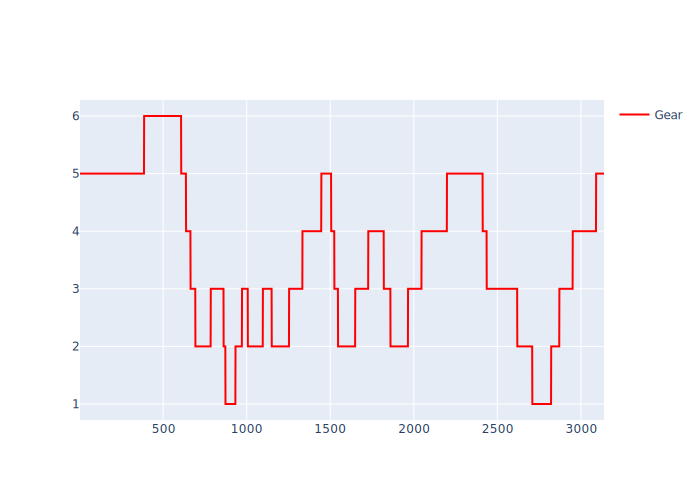

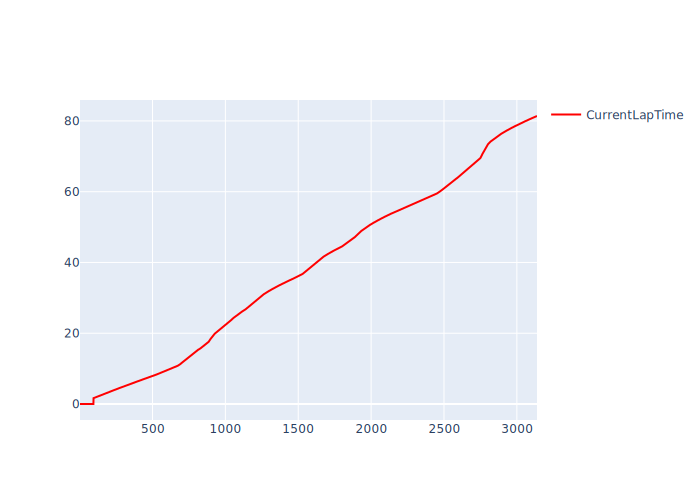

In [4]:
for data_frame in data_frames:
    lap = data_frame["lap"]
    lap_df = data_frame["df"]
    # display(lap_df.head())
    columns = ["Brake", "SpeedMs", "Throttle", "Gear", "CurrentLapTime"]
    lap_df = analyzer.resample(lap_df, columns=columns)
    data_frame["df"] = lap_df

    # window_length = 9  # should be odd and >= polynomial_order + 2
    # polynomial_order = 2
    # lap_df['Throttle'] = scipy.signal.savgol_filter(lap_df['Throttle'], window_length, polynomial_order)

    fig = lap_fig(lap_df)
    fig.update_layout(title=dict(text=f"{lap}"))
    fig.show()

    fig = lap_fig(lap_df, columns=["SpeedMs"])
    fig.show()
    fig = lap_fig(lap_df, columns=["Gear"])
    fig.show()
    fig = lap_fig(lap_df, columns=["CurrentLapTime"])
    fig.show()
    fig.update_layout(title=dict(text=f"{lap}"))

In [5]:
track_df = data_frames[0]["df"].copy()

In [6]:
threshold = track_df["Throttle"].max() * 0.98
display(threshold)
sectors = analyzer.split_sectors(track_df, threshold=threshold, min_length=50)
# for i in range(len(sectors)):
#     display(sectors[i].head())
#     fig = lap_fig(sectors[i])
#     fig.update_layout(title=dict(text=f"{i}"))
#     fig.show()
len(sectors)

0.9800001175999999

9

In [7]:
sector_start_end = analyzer.extract_sector_start_end(sectors, min_length=50)
print(len(sector_start_end))
sector_start_end

9


[{'start': 528, 'end': 813, 'length': 285},
 {'start': 814, 'end': 967, 'length': 153},
 {'start': 968, 'end': 1108, 'length': 140},
 {'start': 1109, 'end': 1439, 'length': 330},
 {'start': 1440, 'end': 1761, 'length': 321},
 {'start': 1762, 'end': 2367, 'length': 605},
 {'start': 2368, 'end': 2575, 'length': 207},
 {'start': 2576, 'end': 2657, 'length': 81},
 {'start': 2658, 'end': 527, 'length': 1007}]

In [8]:
# for i in (0, -1):
#     sector = analyzer.section_df(track_df, sector_start_end[i]['start'], sector_start_end[i]['end'])
#     fig = lap_fig(sector, mode="markers")
#     fig.update_layout(title=dict(text=f"{i}"))
#     fig.show()

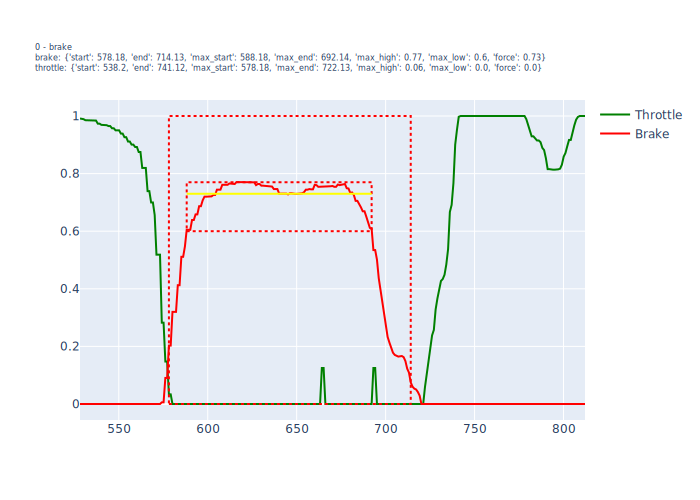

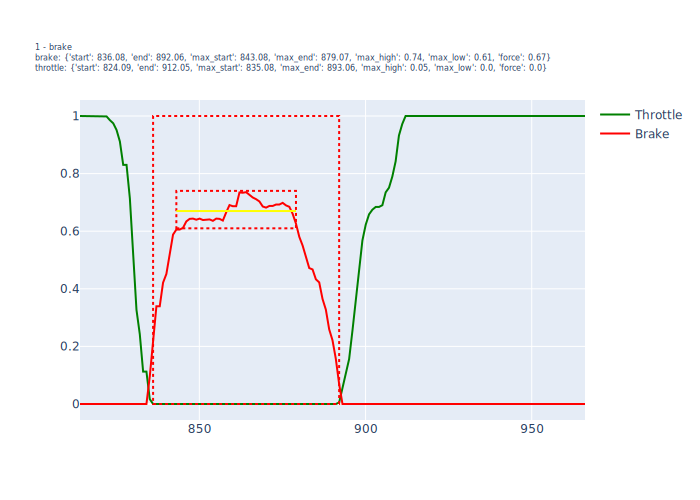

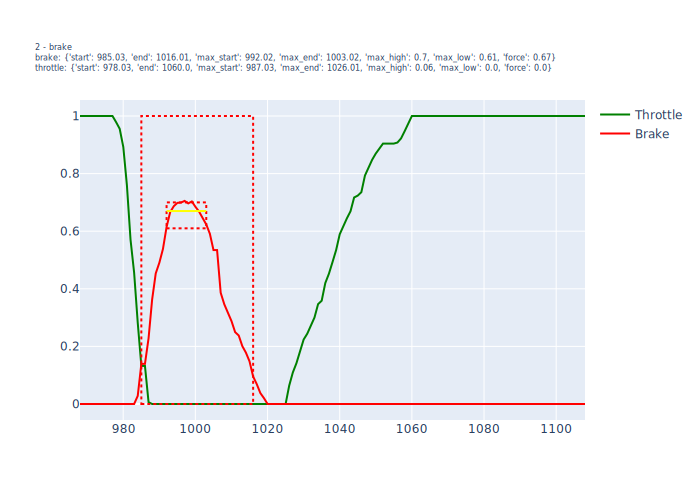

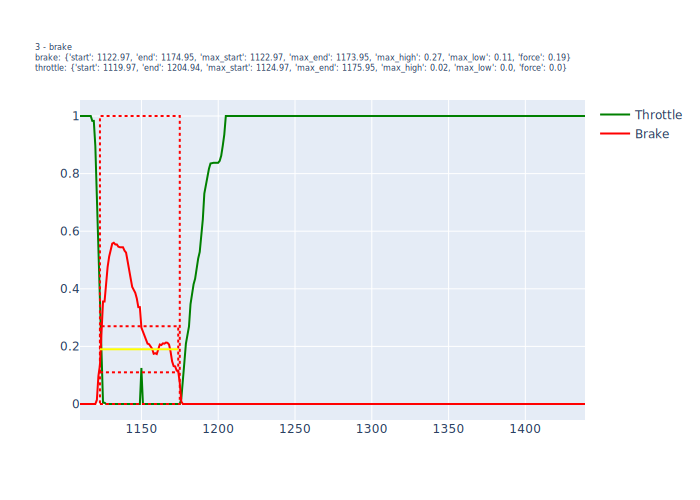

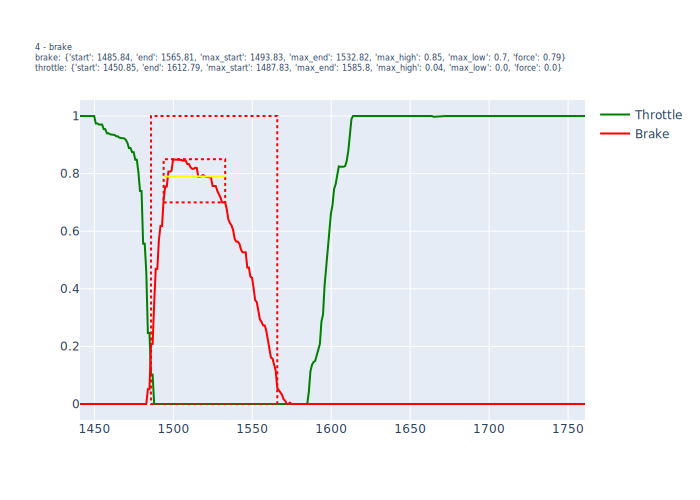

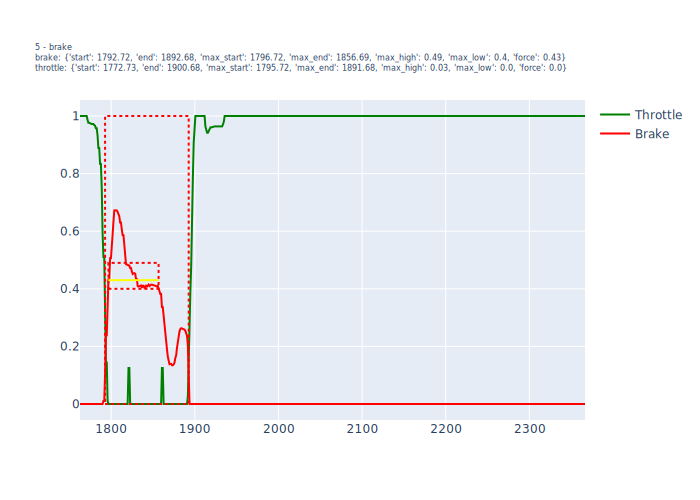

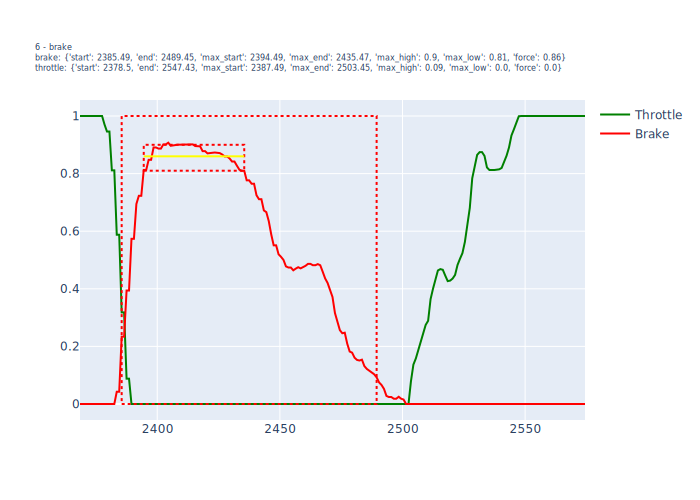

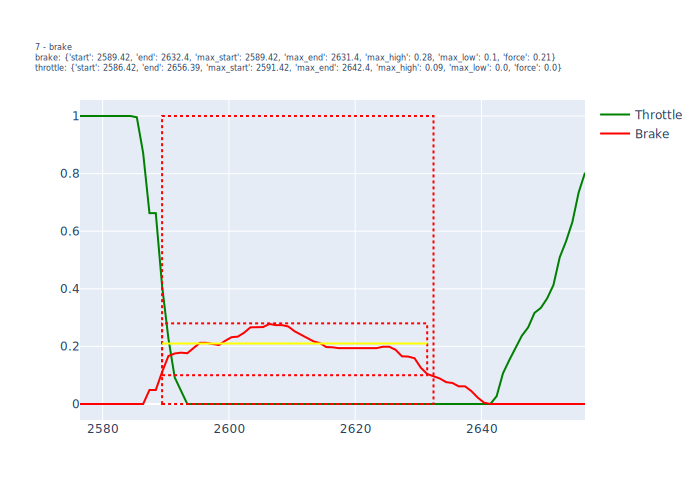

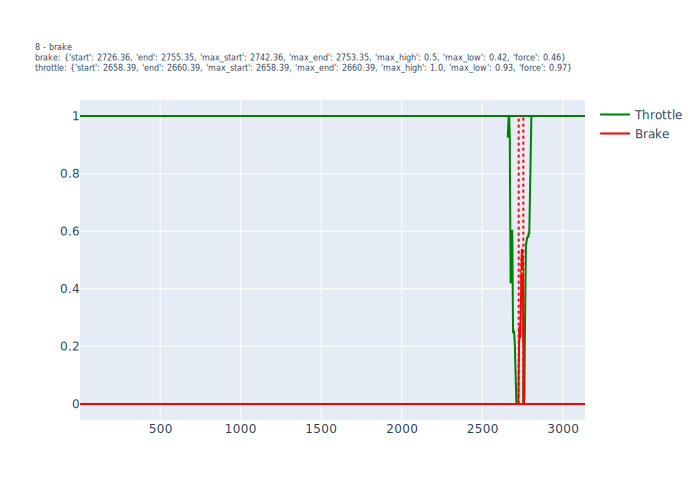

In [9]:
brake_feature_args = {
    "brake_threshold": 0.1,
}
throttle_features_args = {
    # "throttle_threshold": 0.98,
}
sector_dfs = []


def fig_add_features(fig, features, color="red"):
    fig_add_shape(fig, x0=features["start"], x1=features["end"], color=color)
    fig_add_shape(
        fig,
        x0=features["max_start"],
        y0=features["max_low"],
        x1=features["max_end"],
        y1=features["max_high"],
        color=color,
    )
    fig_add_shape(
        fig,
        type="line",
        x0=features["max_start"],
        y0=features["force"],
        x1=features["max_end"],
        y1=features["force"],
        line=dict(color="yellow", width=2),
    )


for i in range(len(sector_start_end)):
    sector = analyzer.section_df(track_df, sector_start_end[i]["start"], sector_start_end[i]["end"])
    sector_dfs.append(sector)
    fig = lap_fig(sector)

    throttle_or_brake = analyzer.sector_type(sector)
    # if throttle_or_brake == "brake":
    #     continue
    # if i != 2:
    #     continue
    # fig.show()
    title = f"{i} - {throttle_or_brake}<br>"

    brake_features = analyzer.brake_features(sector, **brake_feature_args)
    title += f"brake: {brake_features}<br>"
    if brake_features and throttle_or_brake == "brake":
        fig_add_features(fig, brake_features)

    throttle_features = analyzer.throttle_features(sector, **throttle_features_args)
    if throttle_features and throttle_or_brake == "throttle":
        fig_add_features(fig, throttle_features, color="green")
    title += f"throttle: {throttle_features}"

    fig.update_layout(title=dict(text=title, font=dict(size=8)))

    fig.show()

In [23]:
lookup = analyzer.distance_speed_lookup_table(track_df)
# lookup = analyzer.resample(lookup, columns=["SpeedMs", "CurrentLapTime"])

lookup
track_df

/Users/mhild/src/durandom/racing/components/paddock/telemetry/analyzer.py:310: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,DistanceRoundTrack,Brake,SpeedMs,Throttle,Gear,CurrentLapTime
0,2.40000,0.0,56.566876,1.0,5.0,0.00000
1,3.40000,0.0,56.603085,1.0,5.0,0.00000
2,4.40000,0.0,56.673725,1.0,5.0,0.00000
3,5.40000,0.0,56.673725,1.0,5.0,0.00000
4,6.40000,0.0,56.772152,1.0,5.0,0.00000
...,...,...,...,...,...,...
3133,3134.21000,0.0,56.042465,1.0,5.0,81.30946
3134,3135.21000,0.0,56.121937,1.0,5.0,81.34280
3135,3136.21000,0.0,56.165833,1.0,5.0,81.35947
3136,3137.21000,0.0,56.165833,1.0,5.0,81.35947
